In [7]:
#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statsmodels.formula.api as smf
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import het_breuschpagan #Heteroskedasticity test
from statsmodels.stats.diagnostic import het_white #Heteroskedasticity test
from sklearn.metrics import confusion_matrix
from linearmodels import IV2SLS

#Probabilistic programs
#!pip install numpy mkl #if you are in an intel machine i.e. in mac M# chips no
#!pip install pymc
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs 
#IMPORTANT: properly install ipywidgets and nodejs for interactive graphs
#If you are in jupyterlab, activate the widget extension (it should be in the latest versions)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC v5.10.3


# Causal Regression

Textbooks by Matheus Facure Alves:

* Causal Inference for The Brave and True. https://matheusfacure.github.io/python-causality-handbook/landing-page.html

* Causal Inference in Python: Applying Causal Inference in the Tech Industry https://github.com/matheusfacure/causal-inference-in-python-code/tree/main 

## Instrumental variables

Bank: prime credit card to its customers. 

Question: how much the prime card increases customers’ purchase volume (PV).

Instrument:  P prime credit card (prime_eligible) to 10,000 custome.sa 50% chance of being eligible and 50% of being in the controlT the bank can’t force customers to choose the card, making this an experiment with non-compliance
Data:ion on the customer’s age, income, and cr. Purchase volume (pv) Tn on the true effect of the primpvan PV,.)G and which group a custome (prime_elegible). Acceptance of prime card (prime_card)riCd that the complia (categ).to understand:

In [3]:
df = pd.read_csv("prime_card.csv")
df.head()

,age,income,credit_score,prime_elegible,prime_card,pv,tau,categ
0,37.7,9687.0,822.0,0,0,4913.79,700.0,complier
1,46.0,13731.0,190.0,0,0,5637.66,200.0,never-taker
2,43.1,2839.0,214.0,1,1,2410.45,700.0,complier
3,36.0,1206.0,318.0,1,1,1363.06,700.0,complier
4,39.7,4095.0,430.0,0,0,2189.80,700.0,complier


In [20]:
m = smf.ols("pv~prime_card", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2534.4947,19.239,131.740,0.000,2496.783,2572.206
prime_card,588.1388,41.676,14.112,0.000,506.446,669.831


Is prime_card endogenous? Yes. Compliance is not imposed, costumers accepted or not i.e. self selection bias. Those who accepted may also a priori had higher purchase volume (pv).

Two stage least squares logic (2SLS)

<img src="img/IV_11.png" width="400"/>

In [19]:
formula = 'pv ~ 1 + [prime_card ~ prime_elegible]' #put inside square brackets the first stage
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="robust")
print(iv_model.summary.tables[0])
print(iv_model.summary.tables[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:                     pv   R-squared:                      0.0179
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0178
No. Observations:               10000   F-statistic:                    88.548
Date:                Sun, Feb 25 2024   P-value (F-stat)                0.0000
Time:                        15:37:10   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2498.4     23.955     104.29     0.0000      2451.4      2545.3
prime_card     757.70     80.521     9.4100     0.00

Compare with the regular OLS. Estimate is higher with 2SLS. If the instrument is good, trust the IV estimate more, it is less biased.

In [24]:
# Additional controls (outside square brackets) and instruments (inside square brackets)
formula = '''pv ~ 1 
+ [prime_card ~ prime_elegible + credit_score]
+ income + age'''
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="robust")
print(iv_model.summary.tables[0])
print(iv_model.summary.tables[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:                     pv   R-squared:                      0.9581
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9581
No. Observations:               10000   F-statistic:                 2.238e+05
Date:                Sun, Feb 25 2024   P-value (F-stat)                0.0000
Time:                        15:49:21   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      210.62     37.615     5.5992     0.0000      136.89      284.34
income         0.3998     0.0009     469.77     0.00

## Regression discontinuity

Red receive a treatment blues do not. We want to determine if the jump is significant around the cutoff (we assume that around the cutoff, groups are similar i.e. contrafactuals). That is, we look for LATE (local average treatment effect i.e. effect at threshold in the compliers).

<img src="img/RegDis4.png" width="600"/>

Examples: 
* Provide a lower interest rate after an income threshold and check default rates of the clients before and after the cutoff.
* Give insurance discounts before and after an age and check a health outcome
* Provide worker incentives after a sales cutoff and check productivity


In the next example, after some balance in the account, 5000 USD, the bank client can receive a prime card. We want to see if there is a significant jump in purchasing volume pv at 5000 USD.

In [25]:
#Data with discontinuity
df_dd = pd.read_csv("prime_card_discontinuity.csv")
df_dd.head()

,balance,prime_card,pv,tau,categ
0,12100.0,1,356.472,300.0,always-takers
1,4400.0,1,268.172,300.0,always-takers
2,4600.0,1,668.896,300.0,always-takers
3,3500.0,1,428.094,300.0,always-takers
4,12700.0,1,1619.793,700.0,complier


In [43]:
m = smf.ols(f"pv~balance*I(balance>0)", #I(balance>0) because we substract 5000 below i.e. zero is 5000
            df_dd.assign(balance = lambda d: d["balance"] - 5000)).fit(cov_type="HC3")
m.summary() #I(balance>0) estimate tell us if the dep. variable jump is significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pv   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     2982.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:01:07   Log-Likelihood:            -1.4864e+05
No. Observations:               20000   AIC:                         2.973e+05
Df Residuals:                   19996   BIC:                         2.973e+05
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        559.2980      6.547     85.427      0.000     546.466     572.130
I(balance > 0)[T.True]           261.0699      9.046     28.862      0.000     243.341     278.799
balance                            0.0616      0.004     15.855      0.000       0.054       0.069
balance:I(balance > 0)[T.True]    -0.0187      0.004     -4.441      0.000      -0.027      -0.010
==============================================================================
Omnibus:                      679.147   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.862
Skew:                           0.165   Prob(JB):                     1.08e-81
Kurtosis:                       2.418   Cond. No.                     2.00e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

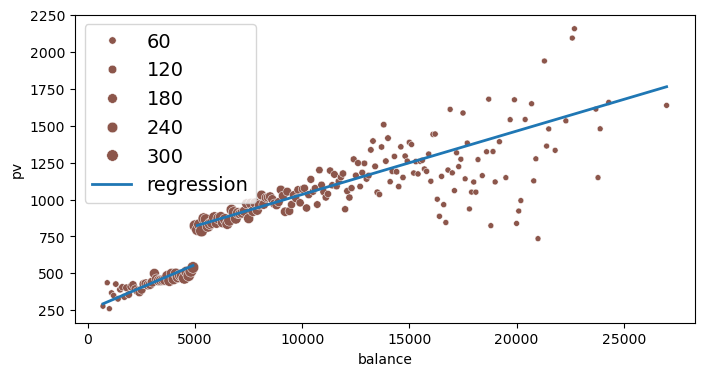

In [30]:
plt_df = df_dd.round({"balance": -2}).assign(size=1).groupby("balance").agg({"pv":"mean", "size": "sum"}).reset_index()

plt.figure(figsize=(8,4))
sns.scatterplot(data=plt_df, y="pv", x="balance", size="size", color="C5")
plt.plot(plt_df.query("balance<5000")["balance"], m.predict(plt_df.query("balance<5000").assign(balance = lambda d: d["balance"] - 5000)), color="C0", lw=2, label="regression")
plt.plot(plt_df.query("balance>5000")["balance"], m.predict(plt_df.query("balance>5000").assign(balance = lambda d: d["balance"] - 5000)), color="C0", lw=2)
plt.legend(fontsize=14);

In [42]:
def rdd_iv(data, y, t, r, cutoff):
    
    centered_df = data.assign(**{r: data[r]-cutoff})
    
    compliance = smf.ols(f"{t}~{r}*I({r}>0)", centered_df).fit()
    itte = smf.ols(f"{y}~{r}*I({r}>0)", centered_df).fit() #intention to treat effect
    
    param = f"I({r} > 0)[T.True]"
    #The return is the formula of the LATE (local average treatment effect i.e. effect for COMPLIERS at threshold)
    #It is the itte divided by proportion of compliers. 
    #If % of compliers is 1, LATE is the jump.
    #If % of compliers is 0.5, the LATE is two times the jump: itte/(1/2) = 2*itte
    #The latter is unintuitive but there is a proof. 
    #And it makes sense. To observe a fixed jump, and say only half complied,
    #then that jump, on average, came from only half the sample, the other half
    #in the itte contributed zero on average, so the compliers contributed twice the mean value
    #to get the observed itte (remember the itte includes non-compliers i.e. intention to treat)
    return itte.params[param]/compliance.params[param] 


print("LATE is local average treatment effect i.e. effect for COMPLIERS at threshold",
      "\nEstimated LATE of prime_card on pv:\n",
      rdd_iv(df_dd, y="pv", t="prime_card", r="balance", cutoff=5000),
     "\nReal effect (we know it because it is a pedagogical / simulated exercise):\n",
     (df_dd
      .round({"balance":-2}) # round to nearest hundred
      .query("balance==5000 & categ=='complier'")["tau"].mean()))

LATE is local average treatment effect i.e. effect for COMPLIERS at threshold 
Estimated LATE of prime_card on pv:
 732.8534752298918 
Real effect (we know it because it is a pedagogical exercise):
 700.0


## Differences in Differences

# Trou Normand 
Bayesian Causal Regressions

In [ ]:
https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/

https://causalpy.readthedocs.io/

